In [2]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import doxapy

from ultralytics import YOLO
from jiwer import wer, cer

In [2]:
model = YOLO("./DAVU_UE2/yolov8n.pt")

In [3]:
img_paths = []

for image in os.listdir("./DAVU_UE2/dataset"):
    if image.endswith(".jpg"):
        img_paths.append(f"./DAVU_UE2/dataset/{image}")

img_paths.sort()

In [4]:
results = model(img_paths)


/home/artur/Uni/2024S/183.628 Document Analysis/document_analysis/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
0: 480x640 1 image, 1 pt, 1: 480x640 1 image, 1 pt, 2: 480x640 2 images, 1 hwt, 1 pt, 3: 480x640 2 images, 1 pt, 4: 480x640 2 images, 1 pt, 5: 480x640 2 images, 1 hwt, 1 pt, 6: 480x640 1 image, 1 pt, 7: 480x640 2 images, 1 pt, 8: 480x640 1 image, 1 pt, 9: 480x640 2 images, 1 pt, 10: 480x640 2 images, 1 pt, 11: 480x640 2 images, 1 pt, 12: 480x640 2 images, 2 pts, 13: 480x640 2 images, 2 hwts, 1 pt, 14: 480x640 2 images, 1 hwt, 1 pt, 15: 480x640 2 images, 1 pt, 16: 480x640 1 image, 1 pt, 17: 480x640 2 images, 1 pt, 18: 480x640 2 images, 3 hwts, 1 pt, 19: 480x640 2 images, 1 hw

In [5]:
for idx, res in enumerate(results):
    res.save_crop("./results/img_" + str(idx+1))

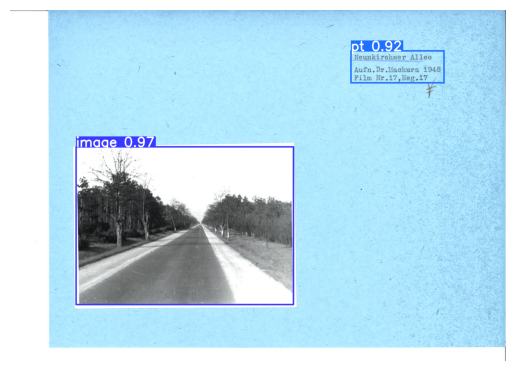

In [6]:
import matplotlib.pyplot as plt

plt.imshow(results[0].plot())
plt.axis('off')
plt.show()

In [7]:
source_directory = "./results"

destination_directory = "./pt_imgs/"

if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)
    
for res in os.listdir(source_directory):
    
    old_name = os.path.join(source_directory + "/" + res + "/pt/im.jpg")
    new_name = os.path.join(source_directory + "/" + res + "/pt/img_" + res.split("_")[1] + ".jpg")
    
    os.rename(old_name, new_name)
    shutil.copy(new_name, destination_directory)

shutil.rmtree(source_directory, ignore_errors=True)

In [8]:
text_dir = "./text"

if not os.path.exists(text_dir):
    os.makedirs(text_dir)

for i in os.listdir(destination_directory):
    if i.endswith(".jpg"):
        img = cv2.imread(destination_directory + i)
        text = pytesseract.image_to_string(img)
        with open(text_dir + "/" + i.split(".")[0].split("_")[1] + ".txt", "w") as f:
            f.write(text)

In [30]:
word_error_rate = []
char_error_rate = []

ground_truth_dir = "./DAVU_UE2/dataset/txt"
gt_files = []

# for i in os.listdir(ground_truth_dir):
#     new_name = ground_truth_dir + "/" + str(int(i.split("_")[0])) + ".txt"
#     os.rename(ground_truth_dir + "/" + i, new_name)

for i in os.listdir(ground_truth_dir):
    gt_files.append(ground_truth_dir + "/" + i)

extr_text_dir = "./text"
et_files = []

for i in os.listdir(extr_text_dir):
    et_files.append(extr_text_dir + "/" + i)

for i in range(len(gt_files)):
    with open(gt_files[i], "r") as f:
        gt_text = f.read()
    with open(et_files[i], "r") as f:
        et_text = f.read()
    word_error_rate.append(wer(gt_text, et_text))
    char_error_rate.append(cer(gt_text, et_text))

mean_wer = round(sum(word_error_rate)/len(word_error_rate), 2)
mean_cer = round(sum(char_error_rate)/len(char_error_rate), 2)

print(f"Mean Word Error Rate: {mean_wer}")
print(f"Mean Character Error Rate: {mean_cer}")

Mean Word Error Rate: 0.99
Mean Character Error Rate: 0.18


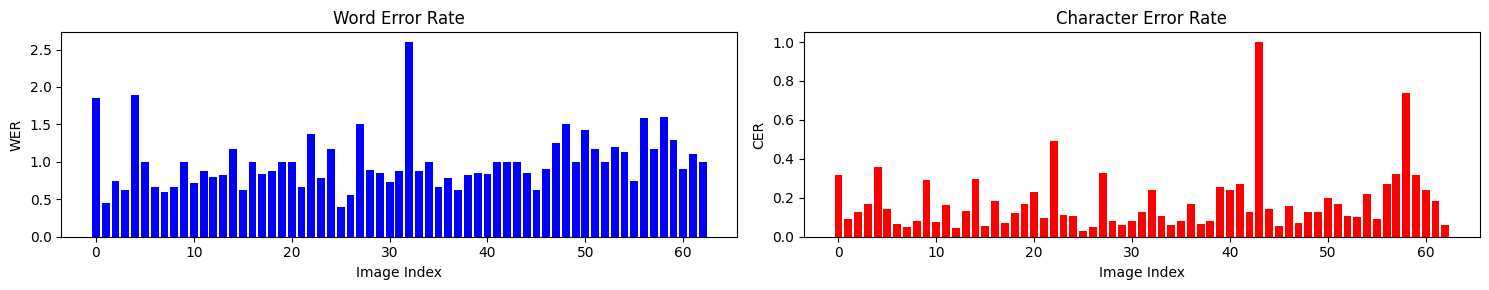

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

ax1.bar(range(len(word_error_rate)), word_error_rate, color='blue')
ax1.set_title("Word Error Rate")
ax1.set_xlabel("Image Index")
ax1.set_ylabel("WER")

ax2.bar(range(len(char_error_rate)), char_error_rate, color='red')
ax2.set_title("Character Error Rate")
ax2.set_xlabel("Image Index")
ax2.set_ylabel("CER")

plt.tight_layout()

plt.show()

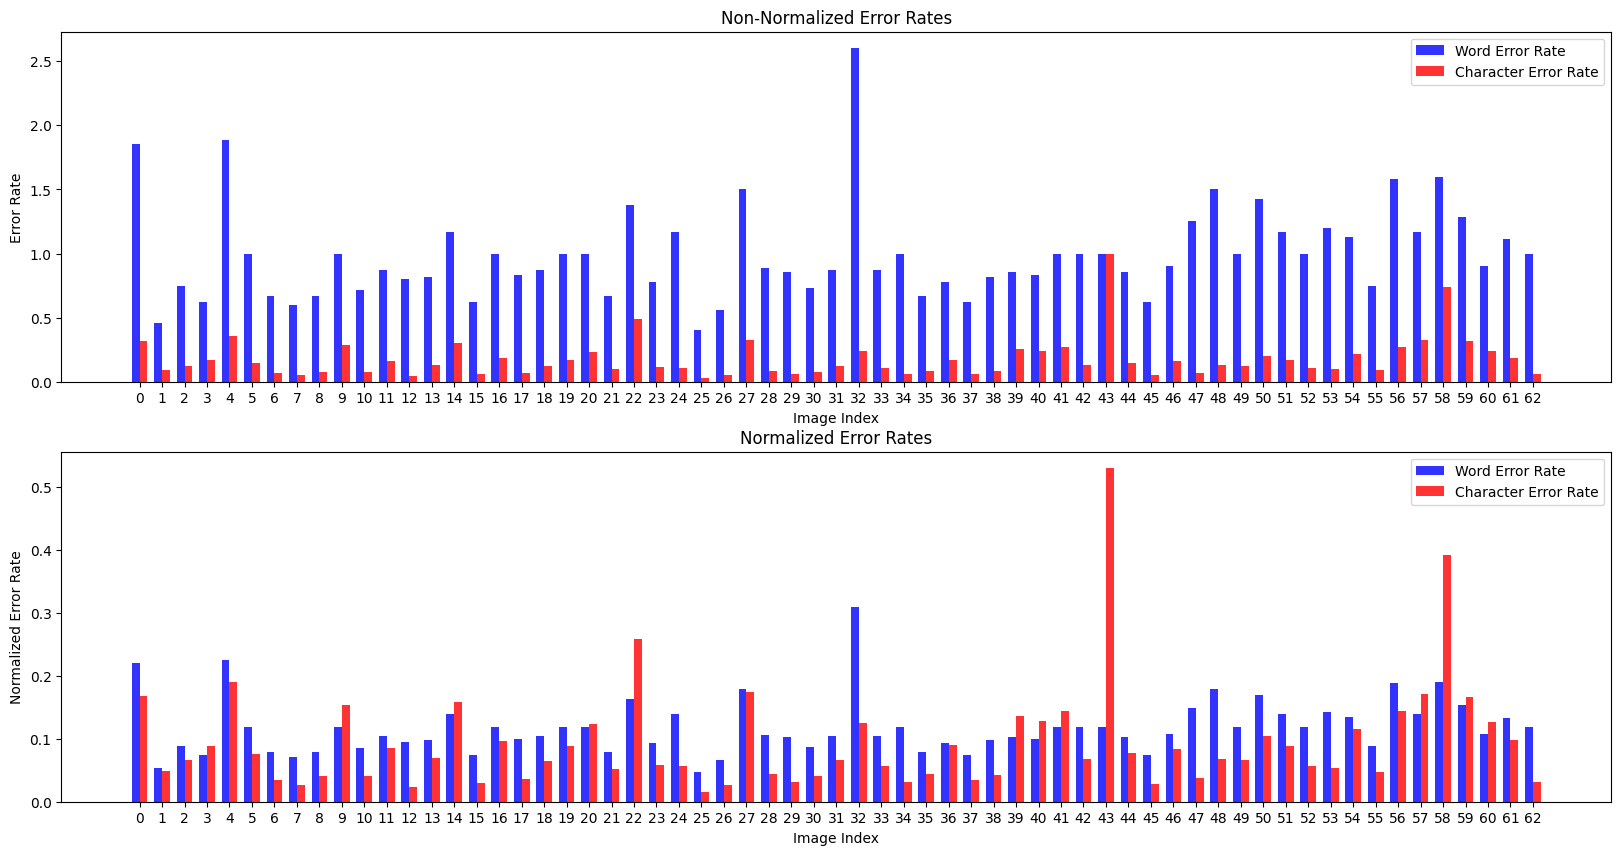

In [58]:
fig, axs = plt.subplots(2, figsize=(20, 10))

index = np.arange(len(word_error_rate))
bar_width = 0.35
opacity = 0.8
axs[0].bar(index, word_error_rate, bar_width, alpha=opacity, color='blue', label='Word Error Rate')
axs[0].bar(index + bar_width, char_error_rate, bar_width, alpha=opacity, color='red', label='Character Error Rate')
axs[0].set_title('Non-Normalized Error Rates')
axs[0].set_xlabel('Image Index')
axs[0].set_ylabel('Error Rate')
axs[0].set_xticks(index + bar_width / 2)
axs[0].set_xticklabels([str(i) for i in index])
axs[0].legend()

norm_word_error_rate = np.array(word_error_rate) / np.linalg.norm(word_error_rate)
norm_char_error_rate = np.array(char_error_rate) / np.linalg.norm(char_error_rate)

index = np.arange(len(norm_word_error_rate))
axs[1].bar(index, norm_word_error_rate, bar_width, alpha=opacity, color='blue', label='Word Error Rate')
axs[1].bar(index + bar_width, norm_char_error_rate, bar_width, alpha=opacity, color='red', label='Character Error Rate')
axs[1].set_title('Normalized Error Rates')
axs[1].set_xlabel('Image Index')
axs[1].set_ylabel('Normalized Error Rate')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels([str(i) for i in index])
axs[1].legend()

plt.show()


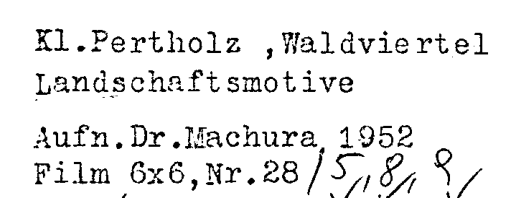

In [11]:
su = doxapy.Binarization(doxapy.Binarization.Algorithms.SU)

imgs = []
for i in os.listdir("./pt_imgs"):
    img = cv2.imread("./pt_imgs/" + i, cv2.IMREAD_GRAYSCALE)
    imgs.append(img)

bin_imgs = []
for img in imgs:
    su.initialize(img)
    su.to_binary(img, {"window": 15})
    bin_imgs.append(img)

plt.imshow(bin_imgs[0], cmap="gray")
plt.axis("off")
plt.show()

In [12]:
dir_name = "./pt_imgs_bin"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
for i in range(len(bin_imgs)):
    cv2.imwrite(f"./pt_imgs_bin/img_{i+1}.jpg", bin_imgs[i])

In [25]:
text_dir = "./text_bin"

if not os.path.exists(text_dir):
    os.makedirs(text_dir)

for i in os.listdir("./pt_imgs_bin"):
        img = cv2.imread("./pt_imgs_bin" + "/" + i)
        text = pytesseract.image_to_string(img)
        with open(text_dir + "/" + i.split(".")[0].split("_")[1] + ".txt", "w") as f:
            f.write(text)

In [26]:
word_error_rate = []
char_error_rate = []

ground_truth_dir = "./DAVU_UE2/dataset/txt"
gt_files = []

# for i in os.listdir(ground_truth_dir):
#     new_name = ground_truth_dir + "/" + str(int(i.split("_")[0])) + ".txt"
#     os.rename(ground_truth_dir + "/" + i, new_name)

for i in os.listdir(ground_truth_dir):
    gt_files.append(ground_truth_dir + "/" + i)

extr_text_dir = "./text_bin"
et_files = []

for i in os.listdir(extr_text_dir):
    et_files.append(extr_text_dir + "/" + i)

for i in range(len(gt_files)):
    with open(gt_files[i], "r") as f:
        gt_text = f.read()
    with open(et_files[i], "r") as f:
        et_text = f.read()
    word_error_rate.append(wer(gt_text, et_text))
    char_error_rate.append(cer(gt_text, et_text))

mean_wer = round(sum(word_error_rate)/len(word_error_rate), 2)
mean_cer = round(sum(char_error_rate)/len(char_error_rate), 2)

print(f"Mean Word Error Rate: {mean_wer}")
print(f"Mean Character Error Rate: {mean_cer}")

Mean Word Error Rate: 1.25
Mean Character Error Rate: 0.75


In [ ]:
def evaluate(gt_path, et_path):
    word_error_rate = []
    char_error_rate = []

    gt_files = []
    for i in os.listdir(gt_path):
        gt_files.append(gt_path + "/" + i)

    et_files = []
    for i in os.listdir(et_path):
        et_files.append(et_path + "/" + i)

    for i in range(len(gt_files)):
        with open(gt_files[i], "r") as f:
            gt_text = f.read()
        with open(et_files[i], "r") as f:
            et_text = f.read()
        word_error_rate.append(wer(gt_text, et_text))
        char_error_rate.append(cer(gt_text, et_text))

    mean_wer = round(sum(word_error_rate)/len(word_error_rate), 2)
    mean_cer = round(sum(char_error_rate)/len(char_error_rate), 2)

    print(f"Mean Word Error Rate: {mean_wer}")
    print(f"Mean Character Error Rate: {mean_cer}")

In [29]:
text_dir = "./text_bin_full_page"

if not os.path.exists(text_dir):
    os.makedirs(text_dir)

for i in os.listdir("./DAVU_UE2/dataset"):
        if i.endswith(".jpg"):
            img = cv2.imread("./DAVU_UE2/dataset" + "/" + i)
            text = pytesseract.image_to_string(img)
            img_idx = str(int(i.split("_")[0]))
            with open(text_dir + "/" + img_idx + ".txt", "w") as f:
                f.write(text)

In [30]:
word_error_rate = []
char_error_rate = []

ground_truth_dir = "./DAVU_UE2/dataset/txt"
gt_files = []

# for i in os.listdir(ground_truth_dir):
#     new_name = ground_truth_dir + "/" + str(int(i.split("_")[0])) + ".txt"
#     os.rename(ground_truth_dir + "/" + i, new_name)

for i in os.listdir(ground_truth_dir):
    gt_files.append(ground_truth_dir + "/" + i)

extr_text_dir = "./text_bin_full_page"
et_files = []

for i in os.listdir(extr_text_dir):
    et_files.append(extr_text_dir + "/" + i)

for i in range(len(gt_files)):
    with open(gt_files[i], "r") as f:
        gt_text = f.read()
    with open(et_files[i], "r") as f:
        et_text = f.read()
    word_error_rate.append(wer(gt_text, et_text))
    char_error_rate.append(cer(gt_text, et_text))

mean_wer = round(sum(word_error_rate)/len(word_error_rate), 2)
mean_cer = round(sum(char_error_rate)/len(char_error_rate), 2)

print(f"Mean Word Error Rate: {mean_wer}")
print(f"Mean Character Error Rate: {mean_cer}")

Mean Word Error Rate: 1.67
Mean Character Error Rate: 0.44


In [39]:
text_dir = "./text_bin_full_page_psm_6"

if not os.path.exists(text_dir):
    os.makedirs(text_dir)

for i in os.listdir("./pt_imgs"):
        if i.endswith(".jpg"):
            img = cv2.imread("./pt_imgs" + "/" + i)
            text = pytesseract.image_to_string(img, config=r'--psm 6')
            with open(text_dir + "/" + i.split(".")[0] + ".txt", "w") as f:
                f.write(text)

In [40]:
word_error_rate = []
char_error_rate = []

ground_truth_dir = "./DAVU_UE2/dataset/txt"
gt_files = []

# for i in os.listdir(ground_truth_dir):
#     new_name = ground_truth_dir + "/" + str(int(i.split("_")[0])) + ".txt"
#     os.rename(ground_truth_dir + "/" + i, new_name)

for i in os.listdir(ground_truth_dir):
    gt_files.append(ground_truth_dir + "/" + i)

extr_text_dir = "./text_bin_full_page_psm_6"
et_files = []

for i in os.listdir(extr_text_dir):
    et_files.append(extr_text_dir + "/" + i)

for i in range(len(gt_files)):
    with open(gt_files[i], "r") as f:
        gt_text = f.read()
    with open(et_files[i], "r") as f:
        et_text = f.read()
    word_error_rate.append(wer(gt_text, et_text))
    char_error_rate.append(cer(gt_text, et_text))

mean_wer = round(sum(word_error_rate)/len(word_error_rate), 2)
mean_cer = round(sum(char_error_rate)/len(char_error_rate), 2)

print(f"Mean Word Error Rate: {mean_wer}")
print(f"Mean Character Error Rate: {mean_cer}")

Mean Word Error Rate: 1.48
Mean Character Error Rate: 0.84


In [41]:
text_dir = "./text_bin_full_page_psm_3"

if not os.path.exists(text_dir):
    os.makedirs(text_dir)

for i in os.listdir("./DAVU_UE2/dataset"):
        if i.endswith(".jpg"):
            img = cv2.imread("./DAVU_UE2/dataset" + "/" + i)
            text = pytesseract.image_to_string(img, config=r'--psm 3')
            img_idx = str(int(i.split("_")[0]))
            with open(text_dir + "/" + img_idx + ".txt", "w") as f:
                f.write(text)

In [43]:
word_error_rate = []
char_error_rate = []

ground_truth_dir = "./DAVU_UE2/dataset/txt"
gt_files = []

# for i in os.listdir(ground_truth_dir):
#     new_name = ground_truth_dir + "/" + str(int(i.split("_")[0])) + ".txt"
#     os.rename(ground_truth_dir + "/" + i, new_name)

for i in os.listdir(ground_truth_dir):
    gt_files.append(ground_truth_dir + "/" + i)

extr_text_dir = "./text_bin_full_page_psm_3"
et_files = []

for i in os.listdir(extr_text_dir):
    et_files.append(extr_text_dir + "/" + i)

for i in range(len(gt_files)):
    with open(gt_files[i], "r") as f:
        gt_text = f.read()
    with open(et_files[i], "r") as f:
        et_text = f.read()
    word_error_rate.append(wer(gt_text, et_text))
    char_error_rate.append(cer(gt_text, et_text))

mean_wer = round(sum(word_error_rate)/len(word_error_rate), 2)
mean_cer = round(sum(char_error_rate)/len(char_error_rate), 2)

print(f"Mean Word Error Rate: {mean_wer}")
print(f"Mean Character Error Rate: {mean_cer}")

Mean Word Error Rate: 1.67
Mean Character Error Rate: 0.44
